# Picking Mushrooms
## Unsupervised Machine Learning Final
### Casey Durfee <casey.durfee@colorado.edu>

I'm going to look at a classic, the mushroom data set [UCI Machine Learning Repository] . It's been done to death online as a supervised learning problem, eg [kaggle] . I think it's a neat dataset, so I'm looking at it as an unsupervised problem.

# 1. Problem Description
Imagine we travel to an alien planet, and we're trying to figure out which mushrooms are safe to eat. Eating them all seems like a bad strategy, but we'd need to do that to build the decision tree (at least for all mushrooms in the training set). Instead, it seems like we could take a bunch of measurements on all the mushrooms, and use an unsupervised algorithm to divide them into piles of mushrooms clustered based on their characteristics, without knowing which are poisonous. We could then sample a few mushrooms from each pile and decide whether the whole pile is safe or not, without having to try them all. An unsupervised method should create better clusters/piles than us just guessing.

I will use unsupervised machine learning algorithms to cluster the training data together, with the goal getting the vast majority of the good mushrooms without eating too many bad ones.

#### References:
[UCI Machine Learning Repository] UCI Machine Learning Repository: Mushroom Data Set. https://archive.ics.uci.edu/ml/datasets/mushroom. Accessed 20 May 2023.    
[kaggle] Mushroom Classification | Kaggle. https://www.kaggle.com/datasets/uciml/mushroom-classification. Accessed 20 May 2023.

# 2. EDA Procedure

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')


from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report

COLUMNS = [ # regex find and replace is your friend
    "Y",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", header=None)
df = df.set_axis(COLUMNS, axis=1)
Y = df.Y
df = df.drop(["Y"], axis=1)
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


The data is categorical; data dictionary can be found at https://www.kaggle.com/datasets/uciml/mushroom-classification

In [3]:
df.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,...,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,...,s,w,w,p,w,o,p,w,v,d
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


There are no null values in any of the columns

In [4]:
df.isna().any()

cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool

though one column has '?' as one of the categories:

In [5]:
df['stalk-root'].value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64

The data is roughly evenly split between edible and poisonous mushrooms.

Since they are roughly balanced, and  I am using unsupervised algorithms, I'm not going to worry about the class imbalance.

In [6]:
Y.value_counts()

e    4208
p    3916
Name: Y, dtype: int64

Let's explore a few attributes.

<Axes: >

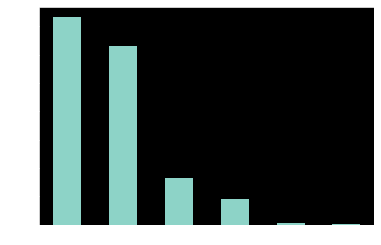

In [7]:
df['cap-shape'].value_counts().plot(kind="bar")


<Axes: >

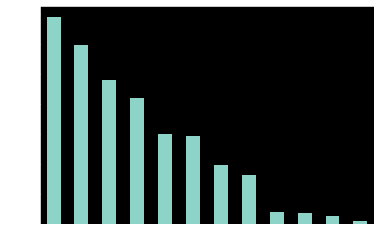

In [8]:
df['gill-color'].value_counts().plot(kind="bar")

These are categorical variables, so we can't just do a quick `df.corr()` to see linkages between attributes. what we can do is one-hot encode it and look for correlations there. Turns out, this is kind of tedious!

The factors are categorical, meaning they have no inherent order to them. So onehot is the only sensible choice for turning them into numbers.

In [9]:
from sklearn import preprocessing

enc = preprocessing.OneHotEncoder()
enc.fit(df)
onehot = enc.transform(df)

onehot

<8124x117 sparse matrix of type '<class 'numpy.float64'>'
	with 178728 stored elements in Compressed Sparse Row format>

need to grab synthetic column names for onehot dataframe.

In [10]:
onehot_features = enc.get_feature_names_out()
onehot_features.shape

(117,)

In [11]:
df_onehot = pd.DataFrame(onehot.toarray(), columns=onehot_features)
df_onehot.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
corrs = df_onehot.corr().unstack().sort_values().drop_duplicates()


In [13]:
corrs =pd.DataFrame(corrs)

corrs = corrs.reset_index()

In [14]:
corrs.columns = ['val1', 'val2', 'correlation']

In [15]:
corrs = corrs[(corrs.correlation < 1.0) | (corrs.correlation > -1.0)]
corrs

,val1,val2,correlation
0,gill-size_n,gill-size_b,-1.000000
1,stalk-shape_e,stalk-shape_t,-1.000000
2,gill-spacing_w,gill-spacing_c,-1.000000
3,bruises_t,bruises_f,-1.000000
4,veil-color_w,stalk-color-below-ring_o,-0.979302
...,...,...,...
5904,ring-type_l,spore-print-color_h,0.868930
5905,spore-print-color_w,stalk-root_?,0.886541
5906,gill-attachment_f,veil-color_w,0.935238
5907,gill-attachment_a,stalk-color-above-ring_o,0.955097


this is a good start, but of course gill-size_n and gill-size_b are correlated with each other. let's knock out the ones in the same factor and ones on the diagonal (1 & -1)

There are a lot of values with a pretty high correlation (.5-.7 range).  there aren't a ton with correlation over .7. so the data is pretty rich but should be amenable to PCA.

In [16]:
corrs = corrs[(corrs.val1.str[:4] != corrs.val2.str[:4])]

corrs[(corrs.correlation.abs() > .7)].sort_values(by=['val1', 'val2'])

,val1,val2,correlation
5907,gill-attachment_a,stalk-color-above-ring_o,0.955097
5906,gill-attachment_f,veil-color_w,0.935238
5902,gill-color_b,spore-print-color_w,0.805573
5890,habitat_w,gill-color_e,0.702866
5897,habitat_w,population_c,0.744425
5891,habitat_w,stalk-color-below-ring_e,0.702866
5901,odor_f,spore-print-color_h,0.799752
5895,ring-type_e,gill-color_b,0.721446
5896,ring-type_l,odor_f,0.723932
5904,ring-type_l,spore-print-color_h,0.868930


## PCA

Are there clusters in the data? we can get a feel by projecting down to 2D and 3D pca.

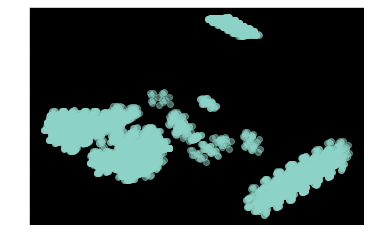

In [17]:
from sklearn.decomposition import PCA

enc_full = preprocessing.OneHotEncoder()
enc_full.fit(df)
df_onehot = enc.transform(df).toarray()

pca = PCA(n_components=2)
pca = pca.fit(df_onehot)

df_pca = pca.transform(df_onehot)

plt.scatter(
         df_pca[:, 0], df_pca[:, 1], alpha=0.5
     )

what about in 3 dimensions? there could be 2 clusters right on top of each other, or one in front of each other. ideally we'd see separation on all 2D slices of the 3D PCA

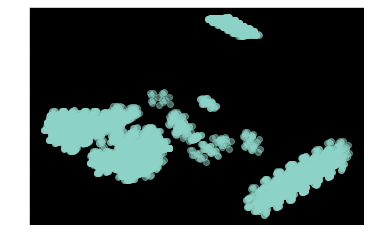

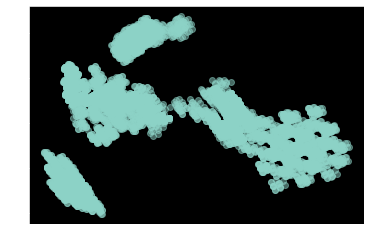

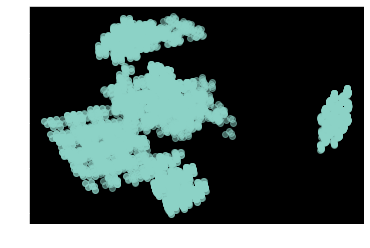

In [18]:
pca3 = PCA(n_components=3) 
pca3 = pca3.fit(df_onehot)

df_pca = pca3.transform(df_onehot)

plt.scatter(
         df_pca[:, 0], df_pca[:, 1], alpha=0.5
     )
plt.show()

plt.scatter(
         df_pca[:, 0], df_pca[:, 2], alpha=0.5
     )
plt.show()

plt.scatter(
         df_pca[:, 1], df_pca[:, 2], alpha=0.5
     )
plt.show()

as they say, thinking in n dimensions is hard, especially for n>3. so I'll stop there. but I think there's clear clusters in the data. of course it's a big assumption that the clusters are homogenous, but let's assume they are for now.

### Matrix Factorization

this is just about the most naive way we can do this. treat 'edible' and 'poisonous' as latent topics; split the onehot data into those topics. we will then need to sample one pile to figure out which one is the poisonous pile (we hope).

A higher number of clusters, eg. `n_components=8` might work better, but I think other methods are more theoretically justified, so I'm not going to optimize this one.

Accuracy: 0.8767848350566223


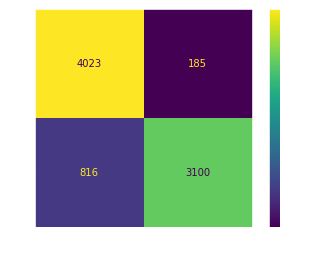

In [19]:
from sklearn.decomposition import NMF

nmf_model = NMF(init='nndsvda', n_components=2)
nmf_fit = nmf_model.fit_transform(df_onehot)

labels = {
    0: 'e',
    1: 'p' # determined by manual inspection
}

nmf_predicted = []
for mushroom in nmf_fit:
    edibility = labels[pd.Series(mushroom).idxmax()]
    nmf_predicted.append(edibility)


cm = confusion_matrix(Y, nmf_predicted)

ConfusionMatrixDisplay(cm).plot()


acc = accuracy_score(Y, nmf_predicted)

print(f"Accuracy: {acc}")

### K-Means Clustering

for k-means clustering, we need to figure out the optimal number of clusters. based on the PCA, it looks like 8-10 is ideal.

One method to find the number of clusters is the elbow method:

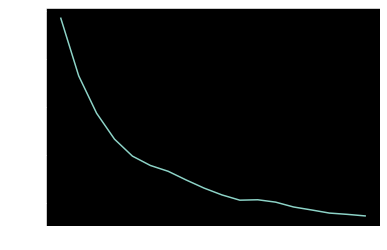

In [20]:
from sklearn.cluster import AgglomerativeClustering, KMeans

def do_elbow(data, start=2, end=10):
    elbow_stats = []

    for x in range(start, end):
        k = KMeans(n_clusters=x, random_state=2178, max_iter=300, init='random')
        k.fit(data)
        elbow_stats.append(k.inertia_)

    plt.plot(range(start,end), elbow_stats)
    plt.show()

do_elbow(df_onehot, start=2, end=20)

not much of an elbow there. let's try the silhouette test instead.

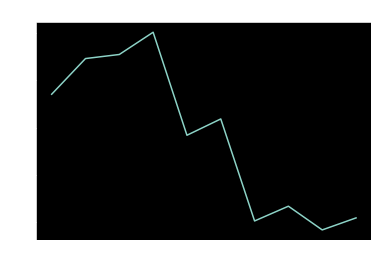

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score


def do_sil(data, start=2, end=10):
    stats = []

    for x in range(start, end):
        k = KMeans(n_clusters=x, random_state=2178, max_iter=300, init='random')
        k.fit(data)
        score = silhouette_score(data, k.labels_)
        stats.append(score)

    plt.plot(range(start,end), stats)


do_sil(df_onehot, 5, 15)
plt.title("Silhouette - One Hot encoding")
plt.show()

yeah, so that confirms the PCA. `k=8` it is.

In [22]:
k_means_model = KMeans(n_clusters=8, random_state=2178, max_iter=300, init='random')

labels = k_means_model.fit_predict(df_onehot)

as discussed in the video, we are going to treat each cluster as a "pile" of mushrooms. we will sample the first few from each pile, and if those are mostly edible, assume the whole pile is edible.

First, we'll make the piles and sample each one.

In [23]:
import collections
piles = collections.defaultdict(list)

picks_dict = {}
bad_sample_mushrooms=0

for x in range(len(labels)):
    pile_on = labels[x]
    truth_on = Y[x]
    piles[pile_on].append(truth_on)

for pile_num, mushrooms in piles.items():
    # pick 5 random mushrooms from the pile
    random_mushrooms = pd.Series(mushrooms).sample(5, random_state=2718)
    vc = random_mushrooms.value_counts()
    if 'p' in vc:
        bad_sample_mushrooms += vc['p']
    consensus = random_mushrooms.mode()[0]
    print(f"{pile_num}, pick {consensus}")
    picks_dict[pile_num] = consensus

5, pick e
3, pick e
7, pick p
2, pick e
4, pick p
6, pick e
1, pick p
0, pick e


then we'll simulate eating the ones where the consensus was edible.

In [24]:
total_edible = total_poison = 0

for (pile_on, consensus) in sorted(picks_dict.items()):
    this_pile = piles[pile_on]
    if consensus == "e":
        print(f">>>eating pile {pile_on}")
        counts = pd.Series(this_pile).value_counts()
        if 'e' in counts:
            total_edible += counts['e']
        if 'p' in counts:
            total_poison += counts['p']
    else:
        print(f"skipping {pile_on} since consensus was nonedible")

print(f"ate {bad_sample_mushrooms} bad mushrooms in sampling")
print(f"Total edible: {total_edible}, Total poison: {total_poison + bad_sample_mushrooms} ({total_edible/(total_edible+total_poison)})")

>>>eating pile 0
skipping 1 since consensus was nonedible
>>>eating pile 2
>>>eating pile 3
skipping 4 since consensus was nonedible
>>>eating pile 5
>>>eating pile 6
skipping 7 since consensus was nonedible
ate 15 bad mushrooms in sampling
Total edible: 4112, Total poison: 427 (0.9089301503094607)


### Agglomerative Clustering

As discussed in the video, a hierarchical approach seems intuitive since we're essentially making a phylogenetic (family) tree of all the mushrooms based on physical properties.

same procedure as before. split into piles, sample each one, eat the good ones, hopefully don't die

In [25]:
glom_model = AgglomerativeClustering(n_clusters=8)
labels = glom_model.fit_predict(df_onehot)

In [26]:
piles = collections.defaultdict(list)

picks_dict = {}

bad_sample_mushrooms = 0

for x in range(len(labels)):
    pile_on = labels[x]
    truth_on = Y[x]
    piles[pile_on].append(truth_on)

for pile_num, mushrooms in piles.items():
    # pick 5 random mushrooms from the pile
    random_mushrooms = pd.Series(mushrooms).sample(5, random_state=2718)
    vc = random_mushrooms.value_counts()
    if 'p' in vc:
        bad_sample_mushrooms += vc['p']
    consensus = random_mushrooms.mode()[0]
    #print(f"{pile_num}, pick {consensus}")
    picks_dict[pile_num] = consensus

total_edible = total_poison = 0

for (pile_on, consensus) in sorted(picks_dict.items()):
    this_pile = piles[pile_on]
    if consensus == "e":
        print(f">>>eating pile {pile_on}")
        counts = pd.Series(this_pile).value_counts()
        if 'e' in counts:
            total_edible += counts['e']
        if 'p' in counts:
            total_poison += counts['p']
    else:
        print(f"skipping {pile_on} since consensus was nonedible")

print(f"ate {bad_sample_mushrooms} bad mushrooms in sampling")
print(f"Total edible: {total_edible}, Total poison: {total_poison + bad_sample_mushrooms} ({total_edible/(total_edible+total_poison)})")

skipping 0 since consensus was nonedible
>>>eating pile 1
>>>eating pile 2
skipping 3 since consensus was nonedible
>>>eating pile 4
skipping 5 since consensus was nonedible
>>>eating pile 6
>>>eating pile 7
ate 15 bad mushrooms in sampling
Total edible: 4016, Total poison: 171 (0.962607861936721)


I'm awfully biased, but that's pretty good! We did have to eat another 20 or so to determine which pile is which, but 171 total is not so bad.

### vs. Supervised Solution (Decision Trees)

How does this compare to a supervised model? we know we will eat some bad mushrooms no matter what, so maybe a supervised model with a training set could get us better results overall. we have to eat a buch of bad mushrooms to train the model, but if the supervised model is good enough, it could still mean fewer poisonous ones eaten.

Accuracy: 0.9948875255623721
Poisonous in training set: 137


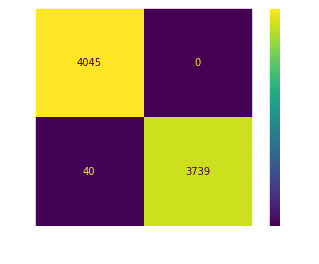

In [27]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split

def do_dt(train_size=300):

  X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(
    df, Y, train_size=train_size, random_state=2718
  )

  enc = preprocessing.OneHotEncoder()#drop=most_common_for_each_factor)
  enc.fit(df)
  X_dt_train_onehot = enc.transform(X_dt_train).toarray()


  X_dt_test_onehot = enc.transform(X_dt_test).toarray()

  ## sklearn decision trees don't support categoricals. which is silly.


  dt_model = DecisionTreeClassifier(random_state=2718)
  dt_model = dt_model.fit(X_dt_train_onehot, y_dt_train)

  dt_predicted = dt_model.predict(X_dt_test_onehot)


  cm = confusion_matrix(y_dt_test, dt_predicted)

  ConfusionMatrixDisplay(cm).plot()


  acc = accuracy_score(y_dt_test, dt_predicted)

  print(f"Accuracy: {acc}")
  print(f"Poisonous in training set: {y_dt_train.value_counts()['p']}")
do_dt()

So, we had to eat 137 poison mushrooms to train the model, but then using the model, we only ended up eating 40 more, for 177 total. That's a little worse than the agglomerative clustering. What about an even smaller training set (note this is arguably data dredging)

Accuracy: 0.9531405782652044
Poisonous in training set: 45


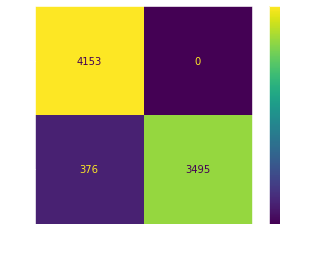

In [28]:
do_dt(100)

it's interesting ALL the errors are type II errors. maybe that says something about the nature of poisonous mushrooms. But the overall number of poison mushrooms eaten here was worse than the 2 clustering examples (but better than matrix factorization with 2 latent topics.)

### k-Nearest Neighbors: This is an easy problem for pretty much any supervised algorithm

in the video, I talked about how easy this problem is. here's an illustration. k-Nearest Neighbors is a clustering algorithm, but it's not really unsupervised if you want to classify things based on kNN because you need to know which ones are edible or poisonous. It wouldn't be anyone's first choice for this problem, I don't think. But it still gets 100% accuracy because this is very "well behaved" data.

1.0


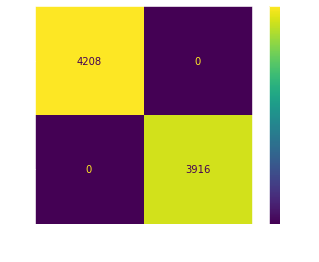

In [29]:
from sklearn import neighbors

neighbor_tree = neighbors.NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df_onehot)

# find the neighbors of each test datapoint in the neighbor tree
distances, indices = neighbor_tree.kneighbors(df_onehot)
nn_nopca_predicted = []
for i in indices:
    neighbor_values = Y[i]
    #print(f"neighbor: {neighbor_values}")
    consensus = neighbor_values.value_counts().idxmax()
    nn_nopca_predicted.append(consensus)


cm = confusion_matrix(Y, nn_nopca_predicted)

ConfusionMatrixDisplay(cm).plot()


acc = accuracy_score(Y, nn_nopca_predicted)

print(acc)

citations given in introduction. some snippets of code adapted from examples on scikit-learn.org